# Hands on timeseries analysis
### part11. Using statistical machine learning for time series forecasting

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2020.11.08 </div> 
<div style="text-align: right"> Last update: 2020.11.08</div> 

지금까지 고전전인 시계열 예측방법에 대해서 살펴보았다.  
지금부터는 머신러닝을 사용한 시계열 예측방법에 대해서 살펴본다.

### 1. 데이터 준비

시계열 예측문제를 머신러닝으로 해결하기 위해서는 데이터셋을 지도학습 모델의 학습에 사용되는 형태로 변형시켜야 한다.
예를 들자면 100, 110, 108, 115, 120.... 과 같은 univarate time series가 있을 때 데이터셋을 입력과 타겟의 형태인 다음과 같이 구성해주어야 한다.    
X : 100, 110, 108, 115, ....
y : 110, 108, 115, 120, ....

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

pd.set_option('display.max_rows', 500)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: list 또는 시계열로된 데이터.
        n_in: 입력 x가 될 lag 수.
        n_out: 출력 y가 될 lead 수.
        dropnan: Null 삭제여부.
    Returns:
        reframe된 데이터프레임.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        if i-1 == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t-%d)' % (j+1, i-1)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [('var%d(t+%d)' % (j+1, i+1)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

`daily-total-female-birth.csv` 데이터셋을 사용한다.

In [3]:
url = 'https://raw.githubusercontent.com/sguys99/datasets/master/daily-total-female-birth.csv'

In [4]:
series = pd.read_csv(url, header=0, index_col=0)

In [5]:
series.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


6시점 전까지 값을 입력으로 사용한다.

In [6]:
data = series_to_supervised(series, n_in=6)

In [7]:
data.shape

(359, 7)

### 2. 모델 학습, 평가

데이터셋 나누는 함수 만들기

In [8]:
def train_test_split(data, n_test):
    return data[: -n_test, :], data[-n_test:, :]

모델 학습하는 함수 만들기

In [9]:
def random_forest_forecast(train, X_test):
    train = np.asarray(train)
    X_train, y_train = train[:, :-1], train[:, -1]
    #X_test = test[:, :-1]
    
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(X_train, y_train)
    yhat = model.predict([X_test])
    return yhat[0]

모델 검증함수 만들기

In [10]:
def walk_forward_validation(data, n_test):
    predictions = list()
    train, test = train_test_split(data, n_test)
    
    history = [x for x in train]
    
    for i in range(len(test)):
        X_test, y_test = test[i, :-1], test[i, -1]
        yhat = random_forest_forecast(history, X_test)
        predictions.append(yhat)
        history.append(test[i])
        
        print('>expected=%.1f, predicted=%.1f' % (y_test, yhat))
        
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

함수 구동하기

In [11]:
mae, y, yhat = walk_forward_validation(data, 12)

>expected=42.0, predicted=45.3
>expected=53.0, predicted=43.6
>expected=39.0, predicted=41.4
>expected=40.0, predicted=38.1
>expected=38.0, predicted=42.6
>expected=44.0, predicted=48.2
>expected=34.0, predicted=42.5
>expected=37.0, predicted=36.9
>expected=52.0, predicted=38.2
>expected=48.0, predicted=41.8
>expected=55.0, predicted=43.8
>expected=50.0, predicted=45.2


In [12]:
print(mae)

5.859083333333333


### 3. 결과 시각화

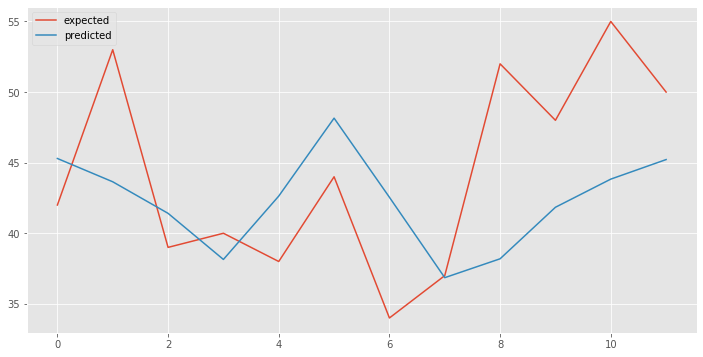

In [13]:
fig, ax = plt.subplots(figsize = (12, 6))
ax = plt.plot(y, label = 'expected')
ax = plt.plot(yhat, label = 'predicted')
plt.legend()
plt.show()